# Models and Predictions for Cured patients
## Data: Covid casses in Macedonia

In [2]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
DATE = "2020-05-05"

Data load

In [3]:
df = pd.read_csv("processed_data.csv")
df.columns = ['Date', 'Infected', 'Fatal', 'Cured']
df.head()

,Date,Infected,Fatal,Cured
0,2020-03-21,9.0,0.0,0.0
1,2020-03-22,29.0,1.0,0.0
2,2020-03-23,22.0,0.0,0.0
3,2020-03-24,12.0,2.0,0.0
4,2020-03-25,29.0,1.0,0.0


Setting date index

In [27]:
df.set_index("Date", drop=False, inplace=True)
df.tail()

,Date,Infected,Fatal,Cured,Infected_mean_lag3,Infected_mean_lag7,Infected_mean_lag30,Infected_std_lag3,Infected_std_lag7,Infected_std_lag30,...,Cured_mean_lag3,Cured_mean_lag7,Cured_mean_lag30,Cured_std_lag3,Cured_std_lag7,Cured_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-09,2020-05-09,36.0,1.0,13.0,20.000000,13.571428,32.400002,11.269427,9.378293,22.409357,...,28.666666,42.000000,34.799999,13.316656,26.369173,31.421934,5,19,9,5
2020-05-10,2020-05-10,36.0,1.0,13.0,27.666666,16.571428,32.066666,11.930353,12.686701,22.274050,...,18.333334,37.428570,35.233334,4.725816,28.453806,31.012438,5,19,10,6
2020-05-11,2020-05-11,22.0,0.0,64.0,28.666666,21.000000,31.666666,12.701706,13.366625,22.084997,...,15.333333,25.714285,35.566666,4.041452,14.020393,30.706264,5,20,11,0
2020-05-12,2020-05-12,10.0,1.0,5.0,31.333334,23.142857,30.799999,8.082904,11.866319,21.931555,...,30.000000,28.142857,37.599998,29.444864,18.933468,30.494318,5,20,12,1
2020-05-13,2020-05-13,20.0,3.0,24.0,22.666666,23.428572,28.866667,13.012815,11.457998,21.079052,...,27.333334,25.857143,37.766666,32.005207,20.812084,30.294741,5,20,13,2


Split location training-testing

In [5]:
loc = int(len(df.Infected) * 0.66)
DATE = df['Date'][loc]

Rolling statistics

In [6]:
df.reset_index(drop=True, inplace=True)
lag_features = ["Infected", "Fatal", "Cured"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]

    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Infected,Fatal,Cured,Infected_mean_lag3,Infected_mean_lag7,Infected_mean_lag30,Infected_std_lag3,Infected_std_lag7,Infected_std_lag30,...,Fatal_mean_lag30,Fatal_std_lag3,Fatal_std_lag7,Fatal_std_lag30,Cured_mean_lag3,Cured_mean_lag7,Cured_mean_lag30,Cured_std_lag3,Cured_std_lag7,Cured_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-21,2020-03-21,9.0,0.0,0.0,30.270441,29.927853,30.311253,12.155816,14.324155,17.184855,...,1.602335,1.156702,1.389606,1.441638,21.798742,20.909704,11.402718,12.603032,13.667277,13.118371
2020-03-22,2020-03-22,29.0,1.0,0.0,9.000000,9.000000,9.000000,12.155816,14.324155,17.184855,...,0.000000,1.156702,1.389606,1.441638,0.000000,0.000000,0.000000,12.603032,13.667277,13.118371
2020-03-23,2020-03-23,22.0,0.0,0.0,19.000000,19.000000,19.000000,14.142136,14.142136,14.142136,...,0.500000,0.707107,0.707107,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-24,2020-03-24,12.0,2.0,0.0,20.000000,20.000000,20.000000,10.148891,10.148891,10.148891,...,0.333333,0.577350,0.577350,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-25,2020-03-25,29.0,1.0,0.0,21.000000,18.000000,18.000000,8.544003,9.201449,9.201449,...,0.750000,1.000000,0.957427,0.957427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Split location training-testing

In [7]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek

Split to train and valid

In [8]:
df_train = df[df.Date < DATE]
df_valid = df[df.Date >= DATE]

#exogenous_features = ["Infected_mean_lag3", "Infected_std_lag3", "Infected_mean_lag7", "Infected_std_lag7",  "Infected_mean_lag30", "Infected_std_lag30", "month", "week", "day", "day_of_week"]
exogenous_features = ["Fatal_mean_lag3", "Fatal_std_lag3", "Fatal_mean_lag7", "Fatal_std_lag7", "Fatal_mean_lag30", "Fatal_std_lag30", "month", "week", "day", "day_of_week"]
#exogenous_features = ["Cured_mean_lag3","Cured_std_lag3", "Cured_mean_lag7", "Cured_std_lag7", "Cured_mean_lag30", "Cured_std_lag30", "month", "week", "day", "day_of_week"]

# ARIMA
    Small dataset -> simpler model. Not using the exogenous features they complicate the model and perform bad.
* *ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.*

In [15]:
model = auto_arima(df_train.Fatal,start_p=1, start_q=1,
                           max_p=5, max_q=5, m=1,
                            #exogenous=df_train[exogenous_features], 
                   trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Fatal, 
          #exogenous=df_train[exogenous_features]
         )

forecast = model.predict(n_periods=len(df_valid), 
                        #exogenous=df_valid[exogenous_features]
                        )
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=128.648, BIC=134.870, Time=0.054 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=131.552, BIC=134.663, Time=0.007 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=131.756, BIC=136.422, Time=0.022 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=129.071, BIC=133.737, Time=0.032 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=156.227, BIC=157.783, Time=0.006 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=130.244, BIC=138.020, Time=0.085 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=123.450, BIC=131.227, Time=0.213 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=123.935, BIC=130.156, Time=0.130 seconds
Near non-invertible roots for order (0, 0, 2)(0, 0, 0, 0); setting score to in

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


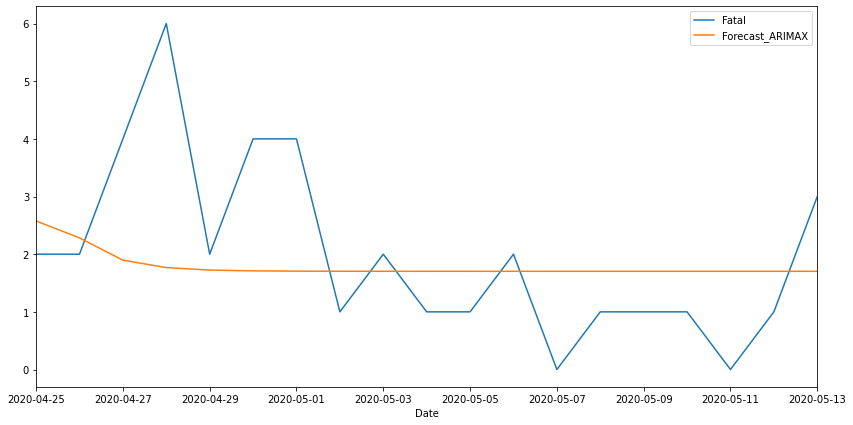

In [16]:
df_valid[["Fatal", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [17]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.Fatal, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.Fatal, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 1.529588035626739

MAE of Auto ARIMAX: 1.1723663822660186


# Facebook Prophet
* *Prophet is an open source library published by Facebook that is based on decomposable (trend+seasonality+holidays) models. It provides us with the ability to make time series predictions with good accuracy using simple intuitive parameters and has support for including impact of custom seasonality and holidays!*

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


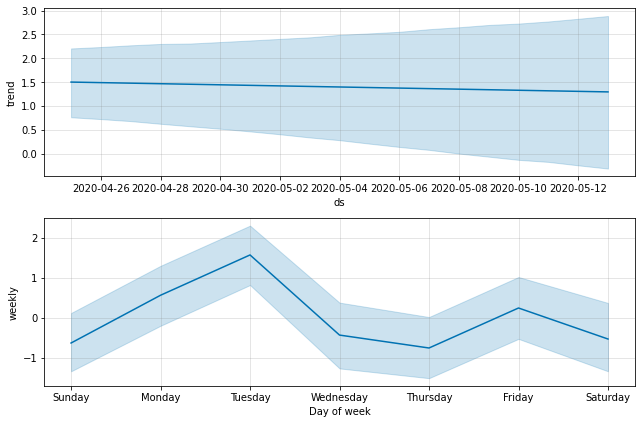

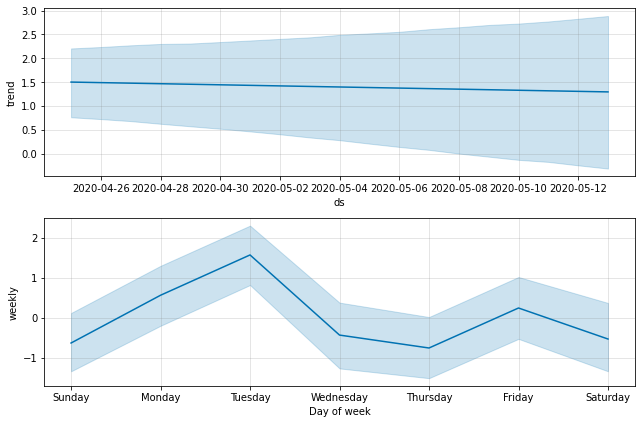

In [19]:
model_fbp = Prophet(mcmc_samples=300)
# for feature in exogenous_features:
#     model_fbp.add_regressor(feature)
    
model_fbp.fit(df_train[["Date", "Fatal"]].rename(columns={"Date": "ds", "Fatal": "y"}))
forecast = model_fbp.predict(df_valid[["Date", "Fatal"]].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values
model_fbp.plot_components(forecast)

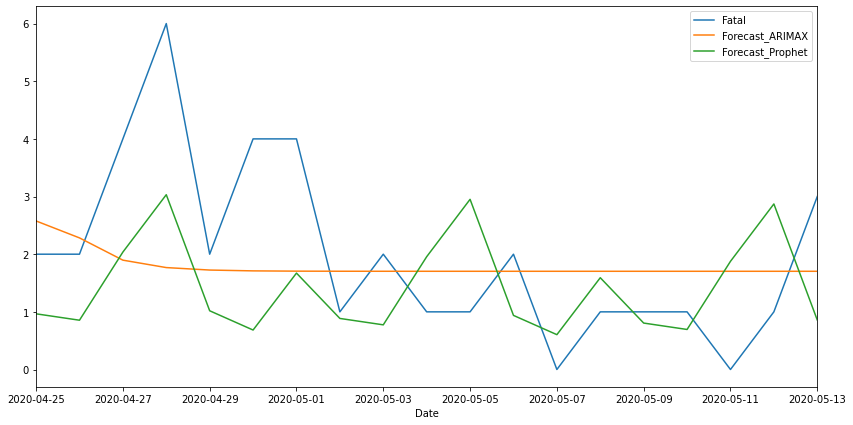

In [20]:
df_valid[["Fatal", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [21]:
print("Model Evaluation")
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.Fatal, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.Fatal, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.Fatal, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.Fatal, df_valid.Forecast_Prophet))

RMSE of Auto ARIMAX: 1.529588035626739
RMSE of Prophet: 1.6581498804698758

MAE of Auto ARIMAX: 1.1723663822660186
MAE of Prophet: 1.4015867474268922


# Predicting new future data

In [31]:
future = model_fbp.make_future_dataframe(periods=22)
future.tail()

,ds
52,2020-05-12
53,2020-05-13
54,2020-05-14
55,2020-05-15
56,2020-05-16


In [32]:
future.set_index("ds", drop=False, inplace=True)
future.tail()

,ds
ds,
2020-05-12,2020-05-12
2020-05-13,2020-05-13
2020-05-14,2020-05-14
2020-05-15,2020-05-15
2020-05-16,2020-05-16


In [36]:
forecast = model_fbp.predict(future)

In [38]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
52,2020-05-12,1.305985,0.301434,5.463610,-0.249174,2.832358,1.565571,0.813713,2.297988,1.565571,0.813713,2.297988,0.0,0.0,0.0,2.871556
53,2020-05-13,1.294525,-1.775773,3.359897,-0.326050,2.883842,-0.436238,-1.269046,0.374562,-0.436238,-1.269046,0.374562,0.0,0.0,0.0,0.858288
54,2020-05-14,1.283066,-2.023131,3.149288,-0.404105,2.925262,-0.758894,-1.512743,0.014206,-0.758894,-1.512743,0.014206,0.0,0.0,0.0,0.524171
55,2020-05-15,1.271606,-1.043134,4.233712,-0.490309,2.968568,0.240187,-0.531194,1.014210,0.240187,-0.531194,1.014210,0.0,0.0,0.0,1.511793
56,2020-05-16,1.260146,-1.990676,3.426603,-0.580658,3.027056,-0.534853,-1.340326,0.366306,-0.534853,-1.340326,0.366306,0.0,0.0,0.0,0.725293


In [39]:
future_pred_all = future
future_pred = future[future.ds >= '2020-05-13']

### Facebook Prophet predictions for 3 days after data

In [41]:
prophet_predictions = {'Date' : forecast[forecast.ds >= '2020-05-13'].ds,
                        'Fatal' : forecast[forecast.ds >= '2020-05-13'].yhat.astype(int)}
prophet_df = pd.DataFrame(prophet_predictions, columns = ['Date', 'Fatal'])
prophet_df

,Date,Fatal
53,2020-05-13,0
54,2020-05-14,0
55,2020-05-15,1
56,2020-05-16,0


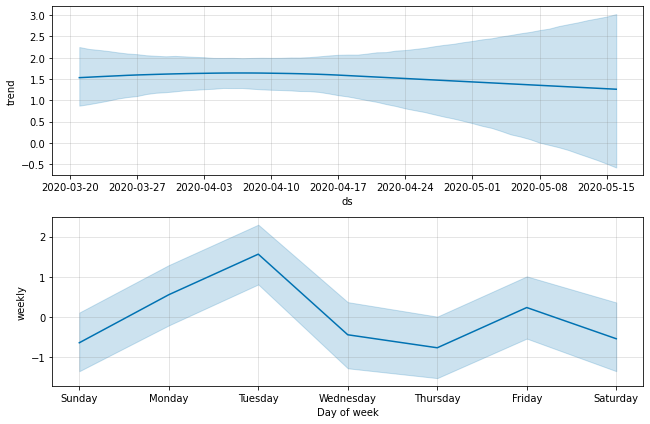

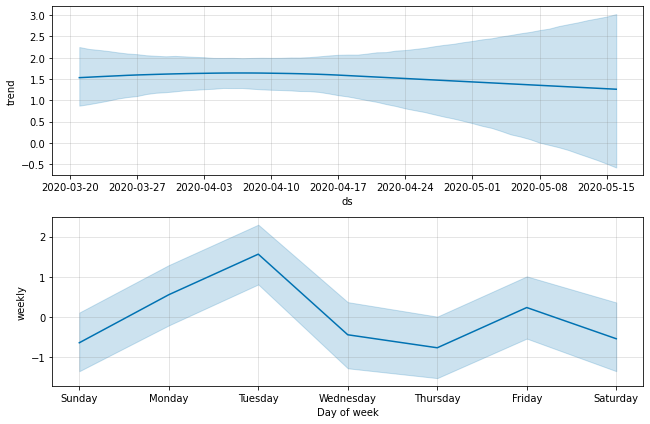

In [42]:
model_fbp.plot_components(forecast)

In [43]:
future_pred["Forecast_Prophet"] = forecast[forecast.ds >= '2020-05-13'].yhat.values
future_pred_all["Forecast_Prophet"] = forecast.yhat.values

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
forecast = model.predict(n_periods=len(future)
                         #, exogenous=df_valid[exogenous_features]
                        )
future_pred["Forecast_ARIMAX"] = forecast[-4:]
future_pred_all["Forecast_ARIMAX"] = forecast

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [45]:
pd.plotting.register_matplotlib_converters()

### ARIMA predictions for 3 days after data

In [48]:
arima_predictions = {'Date' : future[future.ds >= '2020-05-13'].ds,
                        'Fatal' : forecast[-4:].astype(int)}
arima_df = pd.DataFrame(arima_predictions, columns = ['Date', 'Fatal'])
arima_df

,Date,Fatal
ds,,
2020-05-13,2020-05-13,1
2020-05-14,2020-05-14,1
2020-05-15,2020-05-15,1
2020-05-16,2020-05-16,1


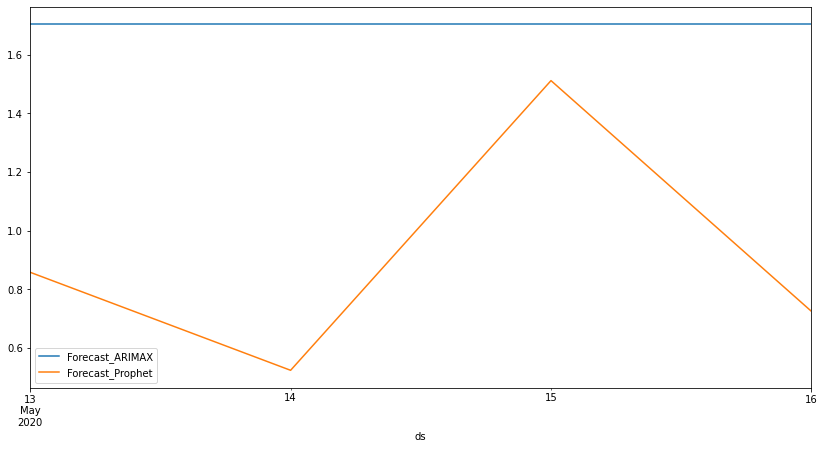

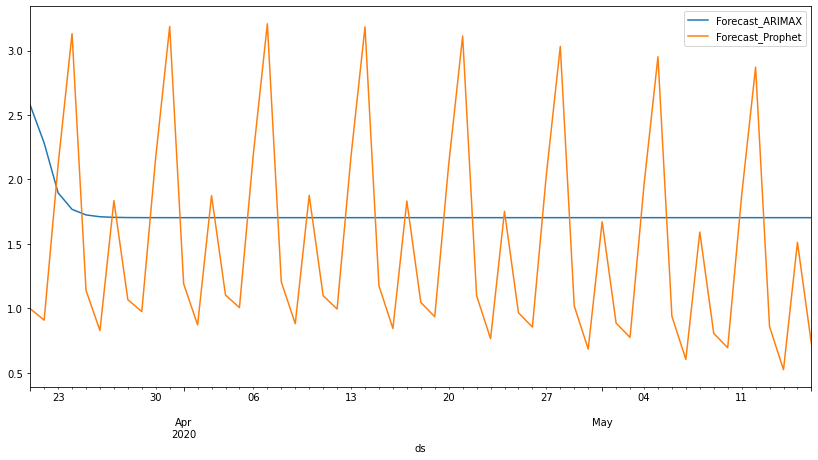

In [46]:
future_pred[["Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))
future_pred_all[["Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))